# Microbenchmarks

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from benchmarks.runner import BenchmarkRunner

In [2]:
chis = [8, 16, 32, 64, 128]
reps = 5
svd_results = []
for chi in chis:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        mat = np.random.randn(chi, chi)
        rec = runner.run_multiple(mat, lambda m: np.linalg.svd(m, full_matrices=False), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    svd_results.append({
        'chi': chi,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
svd_df = pd.DataFrame(svd_results)
svd_df

,chi,mean_time,std_time,mean_mem,std_mem
0,8,0.000131,0.000115,2784.333333,208.666667
1,16,0.000110,0.000007,5816.000000,0.000000
2,32,0.000282,0.000036,18232.000000,0.000000
3,64,0.001184,0.000534,67640.000000,0.000000
4,128,0.004216,0.000696,264762.133333,4.266667


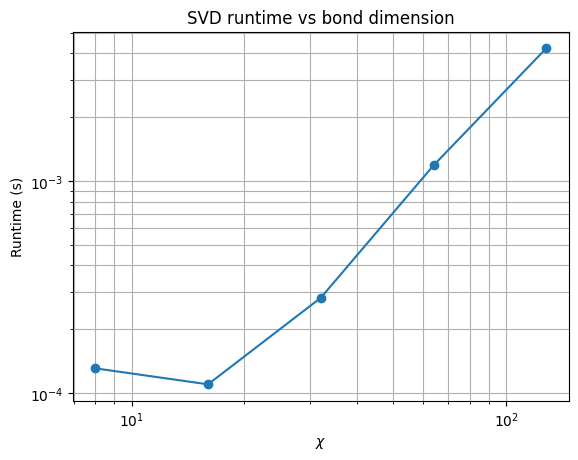

In [3]:
plt.figure()
plt.loglog(svd_df['chi'], svd_df['mean_time'], marker='o')
plt.xlabel(r'$\chi$')
plt.ylabel('Runtime (s)')
plt.title('SVD runtime vs bond dimension')
plt.grid(True, which='both')
plt.show()

In [4]:
frontiers = [10, 50, 200, 1000]
reps = 5
dd_results = []
for r in frontiers:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        data = np.random.rand(r)
        rec = runner.run_multiple(data, lambda x: np.sort(x), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    dd_results.append({
        'frontier': r,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
dd_df = pd.DataFrame(dd_results)
dd_df

,frontier,mean_time,std_time,mean_mem,std_mem
0,10,0.000035,0.000036,2932.2,120.400000
1,50,0.000013,0.000003,3192.0,0.000000
2,200,0.000030,0.000010,4438.4,92.800000
3,1000,0.000041,0.000031,10857.4,99.939182


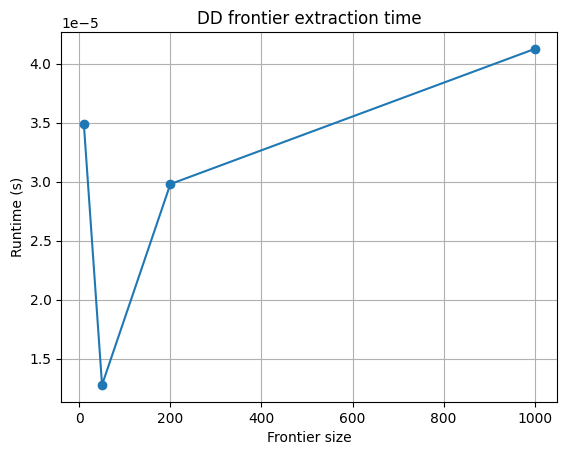

In [5]:
plt.figure()
plt.plot(dd_df['frontier'], dd_df['mean_time'], marker='o')
plt.xlabel('Frontier size')
plt.ylabel('Runtime (s)')
plt.title('DD frontier extraction time')
plt.grid(True)
plt.show()

In [6]:
windows = list(range(2, 9))
reps = 5
st_results = []
for w in windows:
    runner = BenchmarkRunner()
    times = []
    mems = []
    for _ in range(reps):
        rec = runner.run_multiple(w, lambda win: sum(range(1 << win)), repetitions=3)
        times.append(rec['run_time_mean'])
        mems.append(rec['run_peak_memory_mean'])
    st_results.append({
        'window': w,
        'mean_time': np.mean(times),
        'std_time': np.std(times),
        'mean_mem': np.mean(mems),
        'std_mem': np.std(mems)
    })
st_df = pd.DataFrame(st_results)
st_df

,window,mean_time,std_time,mean_mem,std_mem
0,2,0.000005,1.319051e-06,152.000000,0.000000
1,3,0.000004,1.074887e-07,152.000000,0.000000
2,4,0.000004,2.680126e-07,152.000000,0.000000
3,5,0.000005,2.757279e-07,152.000000,0.000000
4,6,0.000005,1.513976e-07,152.000000,0.000000
5,7,0.000006,9.680753e-07,156.266667,8.533333
6,8,0.000007,1.093086e-06,156.266667,8.533333


In [7]:
st_df

,window,mean_time,std_time,mean_mem,std_mem
0,2,0.000005,1.319051e-06,152.000000,0.000000
1,3,0.000004,1.074887e-07,152.000000,0.000000
2,4,0.000004,2.680126e-07,152.000000,0.000000
3,5,0.000005,2.757279e-07,152.000000,0.000000
4,6,0.000005,1.513976e-07,152.000000,0.000000
5,7,0.000006,9.680753e-07,156.266667,8.533333
6,8,0.000007,1.093086e-06,156.266667,8.533333


In [8]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [9]:

# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f"../results/{nb_name}_params.json", 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f"../results/{nb_name}_results.json", 'w') as f:
            json.dump(results, f, indent=2, default=str)
    except TypeError:
        pass
print(json.dumps(_params, indent=2, default=str))


{
  "In": [
    "",
    "import numpy as np\nimport pandas as pd\nimport matplotlib.pyplot as plt\nfrom benchmarks.runner import BenchmarkRunner",
    "chis = [8, 16, 32, 64, 128]\nreps = 5\nsvd_results = []\nfor chi in chis:\n    runner = BenchmarkRunner()\n    times = []\n    mems = []\n    for _ in range(reps):\n        mat = np.random.randn(chi, chi)\n        rec = runner.run_multiple(mat, lambda m: np.linalg.svd(m, full_matrices=False), repetitions=3)\n        times.append(rec['run_time_mean'])\n        mems.append(rec['run_peak_memory_mean'])\n    svd_results.append({\n        'chi': chi,\n        'mean_time': np.mean(times),\n        'std_time': np.std(times),\n        'mean_mem': np.mean(mems),\n        'std_mem': np.std(mems)\n    })\nsvd_df = pd.DataFrame(svd_results)\nsvd_df",
    "plt.figure()\nplt.loglog(svd_df['chi'], svd_df['mean_time'], marker='o')\nplt.xlabel(r'$\\chi$')\nplt.ylabel('Runtime (s)')\nplt.title('SVD runtime vs bond dimension')\nplt.grid(True, which='both'